**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on January 3rd, 2021

In [1]:
%load_ext autoreload
%autoreload 2
import os;
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb

## Set up the statsbombloader

In [3]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote, getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
# datafolder = "../data/statsbomb-epl-1718" # Example of local folder with statsbomb data
# SBL = StatsBombLoader(root=datafolder,getter="local")

## Select competitions to load and convert

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 "Women's World Cup"}

In [5]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name=="FIFA World Cup"]

# # Messi data
# selected_competitions = competitions[competitions.competition_name=="La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name=="FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
17,3,43,FIFA World Cup,International,male,2018


In [6]:
# Get games from all selected competitions
games = list(
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
games = pd.concat(games, sort=True).reset_index(drop=True)
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]
games

,away_score,away_team_id,competition_id,competition_stage,game_date,game_day,game_id,home_score,home_team_id,referee_id,season_id,venue
0,1,776,43,Round of 16,2018-07-01 20:00:00,4,7581,1,785,730.0,3,Stadion Nizhny Novgorod
1,0,793,43,Group Stage,2018-06-22 17:00:00,2,7549,2,775,739.0,3,Volgograd Arena
2,3,769,43,Group Stage,2018-06-24 20:00:00,2,7555,0,789,740.0,3,Kazan' Arena (Kazan')
3,0,775,43,Group Stage,2018-06-16 21:00:00,1,7529,2,785,738.0,3,Stadion Kaliningrad
4,0,795,43,Group Stage,2018-06-22 14:00:00,2,7548,2,781,287.0,3,Saint-Petersburg Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,768,43,3rd Place Final,2018-07-14 16:00:00,7,8657,2,782,741.0,3,Saint-Petersburg Stadium
60,1,774,43,Group Stage,2018-06-19 20:00:00,2,7540,3,796,731.0,3,Saint-Petersburg Stadium
61,1,790,43,Group Stage,2018-06-23 20:00:00,2,7551,2,770,367.0,3,Olimpiyskiy Stadion Fisht
62,2,773,43,Group Stage,2018-06-22 20:00:00,2,7550,1,786,186.0,3,Stadion Kaliningrad


## Load and convert match data

In [7]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [],[]
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).reset_index(drop=True)
#player_games = pd.concat(player_games).reset_index(drop=True)

Loading game data: 100%|███████████████████████████████████████████████████████████████| 64/64 [02:03<00:00,  1.93s/it]


In [8]:
actions

{7581:       game_id                     original_event_id  period_id  time_seconds  \
 0        7581  ec5ba260-9bd3-4c5a-b7a5-9f9168ea905d          1           1.0   
 1        7581  abb799d1-73d8-4119-b23f-40f79765f8f8          1           2.0   
 2        7581  9d3fc438-e85d-49fa-8ff4-21cb3bcc54b1          1           4.0   
 3        7581  5be94fcb-9612-4f00-82b6-3728f4f1b45c          1           7.0   
 4        7581  0370171b-81a7-49e6-809c-3ade48258b5e          1           9.0   
 ...       ...                                   ...        ...           ...   
 2497     7581  354821ab-5ecf-46a4-9412-77b332335f90          5         256.0   
 2498     7581  74cff417-807c-450e-88eb-b4fb7f079644          5         307.0   
 2499     7581  add6775c-ee37-4f91-b5be-8f78f6576916          5         375.0   
 2500     7581  f91e88e9-c1a6-469f-94ae-cfd2934e94ef          5         427.0   
 2501     7581  204dcb31-bf2a-448e-aac2-086a65c7d699          5         484.0   
 
       team_id  play

## Store converted spadl data in a h5-file

In [9]:
datafolder = "../../static/data/Statsbomb/data"

# Create data folder if it doesn't exist
# if not os.path.exists(datafolder):
#     os.mkdir(datafolder)
#     print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [10]:
# Select England vs Belgium game at World Cup
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    game = games[(games.game_id == 7525) ]
#     game = games[(games.competition_name == "FIFA World Cup") 
#                   & (games.away_team_name == "England")
#                   & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    actions = spadlstore[f"actions/game_{game_id}"]
    actions = (
        actions.merge(spadlstore["actiontypes"], how="left")
        .merge(spadlstore["results"], how="left")
        .merge(spadlstore["bodyparts"], how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
# actions[:5]
# actions[2094:2202]
# actions[(actions.type_name == 'shot') & (actions.result_name == 'success')]
# actions['type_name' == "shot", 'result_name' == "success"]
actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,7525,0bf20e26-a131-4484-9e43-db9ba1cbd1be,1,0.0,799,5196,52.058824,33.569620,75.000000,32.708861,0,1,0,0,pass,success,foot,Mohammad Al Sahlawi,Saudi Arabia
1,7525,86733aec-904e-4419-8bd3-08765c3436ef,1,1.0,799,5173,75.000000,32.708861,74.117647,33.569620,21,1,0,1,dribble,success,foot,Abdullah Otayf,Saudi Arabia
2,7525,ca7bbb49-a2fd-473b-ace3-1ccc4da082ee,1,2.0,799,5173,74.117647,33.569620,26.470588,12.911392,0,0,0,2,pass,fail,foot,Abdullah Otayf,Saudi Arabia
3,7525,f37c8329-4e47-4acb-953f-d77d6f4781bd,1,5.0,796,5175,32.647059,10.329114,38.823529,4.303797,0,0,0,3,pass,fail,foot,Ilya Kutepov,Russia
4,7525,eedccd29-1635-4d8c-96d9-2d9639ce40a2,1,7.0,799,5178,38.823529,4.303797,25.588235,4.303797,0,1,0,4,pass,success,foot,Salman Al Faraj,Saudi Arabia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892,7525,8d4d280e-4178-4f57-8fa5-99b2374843cb,2,2867.0,796,5179,86.470588,25.822785,86.470588,23.240506,0,1,0,1892,pass,success,foot,Daler Kuzyaev,Russia
1893,7525,73e049d7-84fb-42ea-9cbe-d0f06b010d7a,2,2867.0,796,5177,86.470588,23.240506,87.352941,22.379747,21,1,0,1893,dribble,success,foot,Aleksandr Golovin,Russia
1894,7525,780ffa22-13c9-49da-9f51-20329e9a08b9,2,2868.0,799,5185,87.352941,22.379747,87.352941,22.379747,8,4,0,1894,foul,yellow_card,foot,Taisir Al Jassim,Saudi Arabia
1895,7525,1a8584e7-a6fe-4f78-9ffe-bc66a513bbc6,2,2937.0,796,5177,86.470588,24.101266,105.000000,30.987342,13,1,0,1895,shot_freekick,success,foot,Aleksandr Golovin,Russia


2018-06-14 17:00:00 Russia 5-0 Saudi Arabia 6'
124    Saudi Arabia
125    Saudi Arabia
126    Saudi Arabia
127    Saudi Arabia
128    Saudi Arabia
Name: team_name, dtype: object


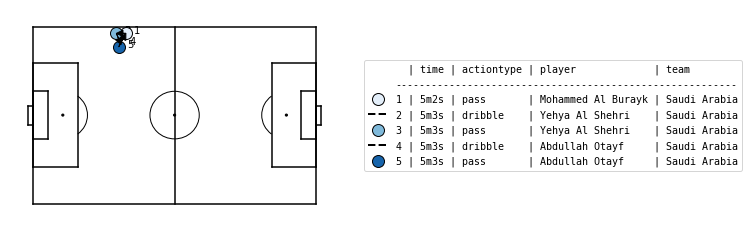

In [11]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
# shot = 2201
shot = 128	

a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "t,ype_name", "player_name", "team_name"]]

print(a.team_name)

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6,
    show=False
)

<KeysViewHDF5 ['actions', 'actiontypes', 'bodyparts', 'competitions', 'games', 'player_games', 'players', 'results', 'teams']>

AttributeError: 'File' object has no attribute 'to_csv'